In [ ]:
!pip install catboost

     |████████████████████████████████| 66.2MB 65kB/s 


In [ ]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# задаем стиль графических построений
sns.set_style()

# скрываем предупреждающие сообщения
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# установливаем параметры matplotlib по умолчанию
COLOR = '#ababab'
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['grid.color'] = COLOR
mpl.rcParams['grid.alpha'] = 0.1

In [ ]:
# импортируем набор данных и создайте датафрейм
df_credit = pd.read_csv('http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0')

In [ ]:
# Просмотр визуально  данных датафрейма
df_credit.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,18.0,18.0,07:52:34,444,outlook.com,NaN,2,0.0,51.0,leidelaura,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,02:34:29,346,gmail.com,0.0,1,0.0,17.0,diocezio,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65023.65,NaN,Ygq6MsM98oC8yceExr69Ig==,PjTIDfJsK0DKL9fO7vuW2g==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,10.0,NaN,00:60:02,6,gmail.com,NaN,2,NaN,9.0,veralucia,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,NaN,54591.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,Cc/kWDLQH3dpHv5HU+pLVA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiE56f...,n+xK9CfX0bCn77lClTWviw==,NaN,1.0,0.0,19.0,19.0,11:20:49,406,spgov.com,NaN,3,NaN,38.0,venice,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,11.0,NaN,13:39:03,240,gmail.com,0.0,2,1.0,46.0,darzisa,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


## Data Analysis

In [ ]:
# Выводим сведения о количестве строк и число полей (атрибутов)
print('Number of rows: ', df_credit.shape[0])
print('Number of columns: ', df_credit.shape[1])

Number of rows:  45000
Number of columns:  43


In [ ]:
# Выводим сведения о количестве null полей (атрибутов)
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 43 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   ids                                               45000 non-null  object 
 1   target_default                                    41741 non-null  object 
 2   score_1                                           44438 non-null  object 
 3   score_2                                           44438 non-null  object 
 4   score_3                                           44438 non-null  float64
 5   score_4                                           45000 non-null  float64
 6   score_5                                           45000 non-null  float64
 7   score_6                                           45000 non-null  float64
 8   risk_rate                                         44438 non-null  float64
 9   last_amount_borro

Некоторые значения полей незаполнены

In [ ]:
# процент пропущенных значений для каждого поля (атрибута)
print((df_credit.isnull().sum() * 100 / df_credit.shape[0]).sort_values(ascending=False))

target_fraud                                        96.617778
last_amount_borrowed                                66.568889
last_borrowed_in_months                             66.568889
ok_since                                            58.988889
external_data_provider_credit_checks_last_2_year    50.284444
external_data_provider_credit_checks_last_year      33.608889
credit_limit                                        30.666667
n_issues                                            25.653333
facebook_profile                                     9.906667
marketing_channel                                    7.951111
job_name                                             7.413333
target_default                                       7.242222
external_data_provider_email_seen_before             4.962222
lat_lon                                              3.028889
user_agent                                           1.604444
n_bankruptcies                                       1.548889
n_defaul

In [ ]:
# удалим все записи, где target_default (наша целевая переменная) равно null.
df_credit.dropna(subset=['target_default'], inplace=True)

In [ ]:
# Удалим колонку с атрибутом "target_fraud", в которй отсутствуют почти все записи
df_credit.drop('target_fraud', axis=1, inplace=True)

In [ ]:
# количество уникальных значений для каждого атрибута
df_credit.nunique().sort_values()

channel                                                 1
external_data_provider_credit_checks_last_2_year        1
last_borrowed_in_months                                 2
target_default                                          2
facebook_profile                                        2
external_data_provider_credit_checks_last_year          2
external_data_provider_credit_checks_last_month         4
real_state                                              5
n_defaulted_loans                                       5
email                                                   6
n_bankruptcies                                          6
score_1                                                 7
marketing_channel                                       9
shipping_state                                         25
score_2                                                35
n_issues                                               44
n_accounts                                             44
state         

In [ ]:
# Удалим колонки "channel" и "external_data_provider_credit_checks_last_2_year"
df_credit.drop(labels=['channel', 'external_data_provider_credit_checks_last_2_year'], axis=1, inplace=True)

In [ ]:
# удалим некоторые столбцы, которые не добавляют ценности модели
df_credit.drop(labels=['email', 'reason', 'zip', 'job_name', 'external_data_provider_first_name', 'lat_lon',
                       'shipping_zip_code', 'user_agent', 'profile_tags', 'marketing_channel',
                       'profile_phone_number', 'application_time_applied', 'ids'], axis=1, inplace=True)

In [ ]:
# проверим, есть ли в наборе данных выбросы. Покажем статистику
df_credit.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income
count,41741.000000,41741.000000,41741.000000,41741.000000,41741.000000,14133.000000,14133.000000,28632.000000,4.174100e+04,17276.000000,41606.000000,41729.000000,41741.000000,30818.000000,41741.000000,41741.000000,27720.000000,39656.000000,41741.000000,41741.0
mean,346.459836,100.006820,0.499416,99.919399,0.294451,13328.104095,40.588410,33877.220453,7.108012e+04,35.192174,0.076696,0.004625,10.639108,11.023882,247.748545,1.504396,0.504185,12.731188,500.491771,inf
std,110.102271,3.183821,0.288085,10.022703,0.101561,7918.698433,9.437936,36141.985884,5.225978e+04,21.629577,0.274820,0.080157,4.588175,4.596036,146.326172,1.114207,0.499992,125.711218,287.993121,NaN
min,0.000000,86.191572,0.000035,60.663039,0.000000,1005.180000,36.000000,0.000000,4.821180e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-999.000000,0.000000,403.0
25%,270.000000,97.862546,0.251595,93.182517,0.220000,7210.280000,36.000000,9975.000000,4.401958e+04,17.000000,0.000000,0.000000,7.000000,8.000000,120.000000,1.000000,0.000000,11.000000,252.000000,50910.0
50%,340.000000,100.017950,0.500174,99.977774,0.290000,12011.050000,36.000000,25213.000000,6.004409e+04,32.000000,0.000000,0.000000,10.000000,10.000000,248.000000,2.000000,1.000000,27.000000,502.000000,101623.0
75%,420.000000,102.143100,0.747630,106.630991,0.360000,18030.160000,36.000000,46492.500000,8.503289e+04,50.000000,0.000000,0.000000,13.000000,14.000000,375.000000,2.000000,1.000000,43.000000,747.000000,151248.0
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,5.000000,5.000000,49.000000,49.000000,500.000000,3.000000,1.000000,59.000000,1000.000000,inf


In [ ]:
# количество значений "inf" в "reported_income"
np.isinf(df_credit['reported_income']).sum()

66

In [ ]:
# количество значений = -999 в "external_data_provider_email_seen_before"
df_credit.loc[df_credit['external_data_provider_email_seen_before'] == -999, 'external_data_provider_email_seen_before'].value_counts()

-999.0    591
Name: external_data_provider_email_seen_before, dtype: int64

заменим эти значения "inf" и "-999" на NaN, чтобы мы могли построить гистограммы для визуализации распределения значений

In [ ]:
# замена "inf" на "nan"
df_credit['reported_income'] = df_credit['reported_income'].replace(np.inf, np.nan)

# замена "-999" на "nan"
df_credit.loc[df_credit['external_data_provider_email_seen_before'] == -999, 'external_data_provider_email_seen_before'] = np.nan

Построим гистограммы для этих характеристик, что поможет изучить их распределение

In [ ]:
# фрейм данных, содержащий числовые характеристики
df_credit_numerical = df_credit[['score_3', 'risk_rate', 'last_amount_borrowed',
                                 'last_borrowed_in_months', 'credit_limit', 'income', 'ok_since',
                                 'n_bankruptcies', 'n_defaulted_loans', 'n_accounts', 'n_issues',
                                 'external_data_provider_email_seen_before']]

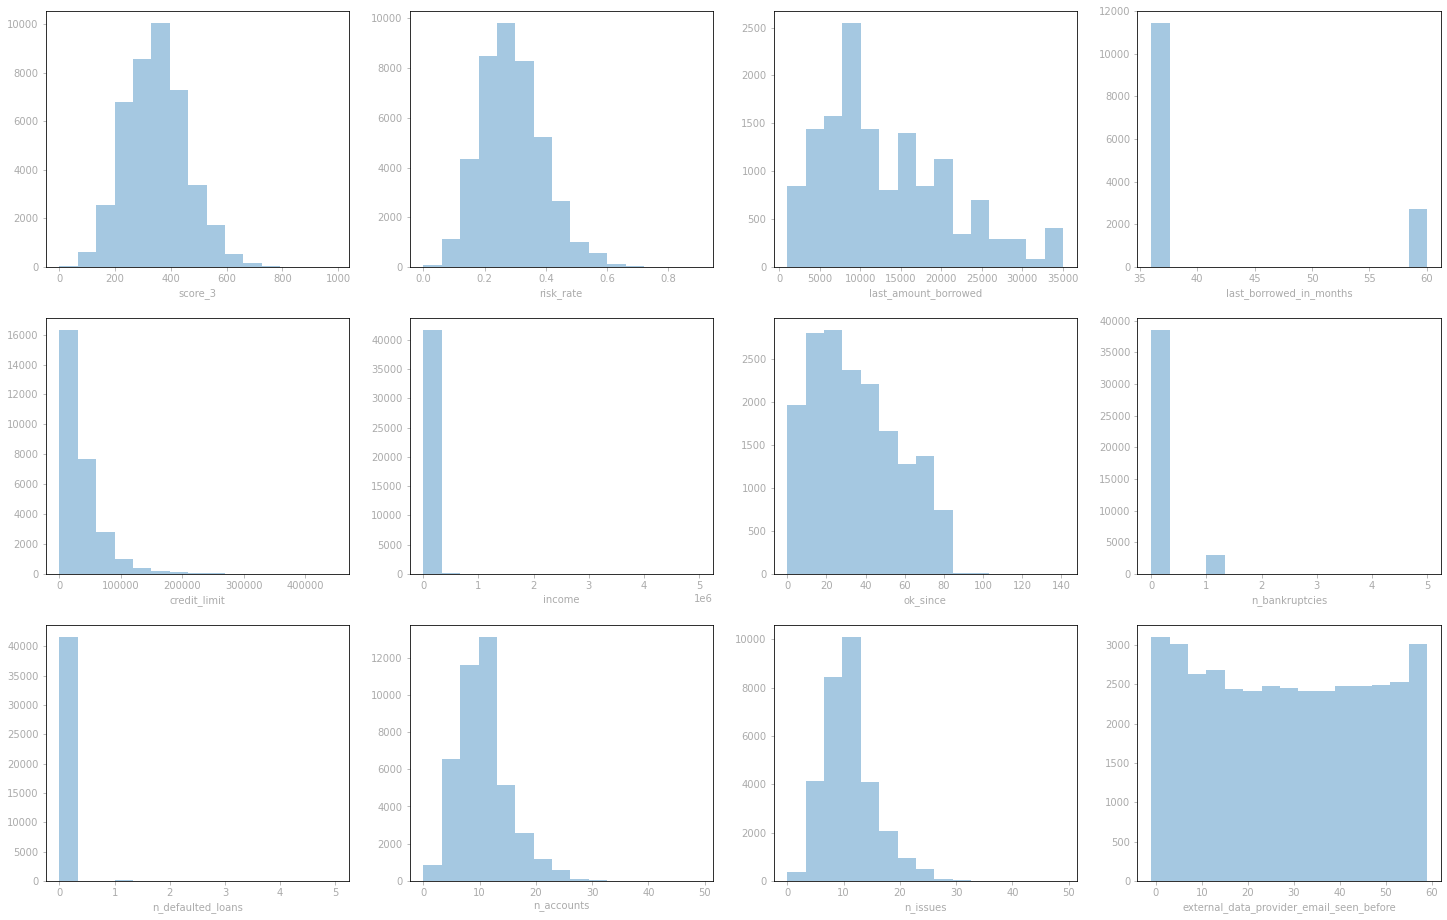

In [ ]:
# построим гистограммы для каждого из приведенных выше объектов

nrows = 3
ncols = 4

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 16))

r = 0
c = 0

for i in df_credit_numerical:
  sns.distplot(df_credit_numerical[i], bins=15,kde=False, ax=ax[r][c])
  if c == ncols - 1:
    r += 1
    c = 0
  else:
    c += 1

plt.show()

Все перечисленные выше объекты имеют пропущенные значения, которые необходимо обработать. Как мы можем видеть, они имеют искаженное распределение, что указывает на то, что мы должны заполнить пропущенные значения медианным значением для каждого объекта.

 Заполняем значения из оставшихся 32 столбцов с пропущенными значениями в соответствии с особенностями каждого признака, как показано ниже:

1. Категориальные переменные будут заполнены наиболее повторяющимся значением.
2. Числовые переменные будут заполнены их средними значениями.
3. В конкретных случаях last_amount_borrowed, last_borrowed_in_months и n_issues мы заполним недостающие значения нулем, поскольку разумно полагать, что не каждому клиенту будут присвоены значения этим переменным.



In [ ]:
df_credit_num = df_credit.select_dtypes(exclude='object').columns
df_credit_cat = df_credit.select_dtypes(include='object').columns

# fill missing values for "last_amount_borrowed", "last_borrowed_in_months" and "n_issues"
df_credit['last_amount_borrowed'].fillna(value=0, inplace=True)
df_credit['last_borrowed_in_months'].fillna(value=0, inplace=True)
df_credit['n_issues'].fillna(value=0, inplace=True)

# fill missing values for numerical variables
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer = imputer.fit(df_credit.loc[:, df_credit_num])
df_credit.loc[:, df_credit_num] = imputer.transform(df_credit.loc[:, df_credit_num])

# fill missing values for categorical variables
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = imputer.fit(df_credit.loc[:, df_credit_cat])
df_credit.loc[:, df_credit_cat] = imputer.transform(df_credit.loc[:, df_credit_cat])

In [ ]:
# Проверяем полученный новый датафрейм на наличие нулейвых значений полей (атрибутов)
df_credit.isnull().sum()

target_default                                     0
score_1                                            0
score_2                                            0
score_3                                            0
score_4                                            0
score_5                                            0
score_6                                            0
risk_rate                                          0
last_amount_borrowed                               0
last_borrowed_in_months                            0
credit_limit                                       0
income                                             0
facebook_profile                                   0
state                                              0
real_state                                         0
ok_since                                           0
n_bankruptcies                                     0
n_defaulted_loans                                  0
n_accounts                                    

проведем предварительную обработку данных, преобразовав категориальные признаки в числовые значения. `LabelEncoder` будет использоваться для двоичных переменных, в то время как `get_dummies` будет использоваться для других категориальных переменных.

In [ ]:
bin_var = df_credit.nunique()[df_credit.nunique() == 2].keys().tolist()
num_var = [col for col in df_credit.select_dtypes(['int', 'float']).columns.tolist() if col not in bin_var]
cat_var = [col for col in df_credit.select_dtypes(['object']).columns.tolist() if col not in bin_var]

df_credit_encoded = df_credit.copy()

# label encoding for the binary variables
le = LabelEncoder()
for col in bin_var:
  df_credit_encoded[col] = le.fit_transform(df_credit_encoded[col])

# encoding with get_dummies for the categorical variables
df_credit_encoded = pd.get_dummies(df_credit_encoded, columns=cat_var)

df_credit_encoded.head()

,target_default,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,facebook_profile,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,score_1_1Rk8w4Ucd5yR3KcqZzLdow==,score_1_4DLlLW62jReXaqbPaHp1vQ==,score_1_8k8UDR4Yx0qasAjkGrUZLw==,score_1_DGCQep2AE5QRkNCshIAlFQ==,score_1_e4NYDor1NOw6XKGE60AWFw==,score_1_fyrlulOiZ+5hoFqLa6UbDQ==,score_1_smzX0nxh5QlePvtVf6EAeg==,score_2_+2hzpeP1RWr8PEvL1WTUdw==,score_2_+CxEO4w7jv3QPI/BQbyqAA==,score_2_/tdlnWjXoZ3OjdtBXzdOJQ==,score_2_5/uMrqKj3OL/Xk5OrGx9fg==,score_2_55UK234RR1d7HIWJjmq9tw==,score_2_6J1ZMTzN5GKHXnhM4J1JbA==,score_2_7h+tk4z7O9brtBSe1rNjxA==,score_2_7h8PTkrlTWUPP3yuyP4rUg==,score_2_A+QuW1n/ABeiVVe/9CRZ9Q==,score_2_Fv28Bz0YRTVAT5kl1bAV6g==,score_2_IOVu8au3ISbo6+zmfnYwMg==,...,state_kfFcVGcsJmH2n3eYprLkeQ==,state_orU7WJYGPT/xFwOXY1eBkw==,state_qItmSqWrjm+MopDA+UpKRw==,state_rrVbgRNTRyB6auEycsRrpA==,state_sjJbkqJS7cXalHLBFA+EOQ==,state_umkEte5GXWggFkMOtKQ3Ug==,state_x6Gw/1I8t3KPgT6s82Kodg==,state_xsd3ZdsI3356I3xMxZeiqQ==,state_ygE7OTdsxRMLeXMa0EZwZw==,state_yni6lL4oSly97UVZeRSyxA==,real_state_+qWF9pJpVGtTFn4vFjb/cg==,real_state_N5/CE7lSkAfB04hVFFwllw==,real_state_UX7AdFYgQh+VrVC5eIaU9w==,real_state_n+xK9CfX0bCn77lClTWviw==,real_state_nSpvDsIsslUaX6GE6m6eQA==,shipping_state_BR-AC,shipping_state_BR-AL,shipping_state_BR-AM,shipping_state_BR-AP,shipping_state_BR-BA,shipping_state_BR-CE,shipping_state_BR-DF,shipping_state_BR-ES,shipping_state_BR-GO,shipping_state_BR-MA,shipping_state_BR-MG,shipping_state_BR-MS,shipping_state_BR-MT,shipping_state_BR-PA,shipping_state_BR-PB,shipping_state_BR-PE,shipping_state_BR-PR,shipping_state_BR-RN,shipping_state_BR-RO,shipping_state_BR-RR,shipping_state_BR-RS,shipping_state_BR-SC,shipping_state_BR-SE,shipping_state_BR-SP,shipping_state_BR-TO
0,0,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,65014.12,1,32.0,0.0,0.0,18.0,18.0,444.0,2.0,0,51.0,645.0,57849.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,370.0,97.062615,0.942655,92.002546,0.24,0.00,0.0,39726.0,100018.91,0,50.0,0.0,0.0,14.0,14.0,346.0,1.0,0,17.0,243.0,4902.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,25213.0,65023.65,0,32.0,0.0,0.0,10.0,0.0,6.0,2.0,1,9.0,65.0,163679.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,510.0,101.599485,0.987673,94.902491,0.32,0.00,0.0,54591.0,68830.01,0,32.0,1.0,0.0,19.0,19.0,406.0,3.0,1,38.0,815.0,1086.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,500.0,98.474289,0.532539,118.126207,0.18,0.00,0.0,25213.0,60011.29,1,32.0,0.0,0.0,11.0,0.0,240.0,2.0,1,46.0,320.0,198618.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


Работа над моделями машинного обучения.

In [ ]:
# Feature  matrix — это инструмент управления продуктом, который помогает командам определить, какие функции разрабатывать дальше.
X = df_credit_encoded.drop('target_default', axis=1)

# целевая переменная (целевой атрибут)
y = df_credit_encoded['target_default']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y)

Поскольку мы имеем дело с несбалансированным набором данных, мы стандартизируем и повторно выполним выборку обучающего набора с помощью `StandardScaler` и `RandomUnderSampler` соответственно.

In [ ]:
# стандартизируем числовые переменные
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# повторная выборка
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

In [ ]:
# определим функцию val_model
def val_model(X, y, clf, show=True):
    """
    Apply cross-validation on the training set.

    # Arguments
        X: DataFrame containing the independent variables.
        y: Series containing the target vector.
        clf: Scikit-learn estimator instance.

    # Returns
        float, mean value of the cross-validation scores.
    """

    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if show == True:
        print(f'Recall: {scores.mean()}, {scores.std()}')

    return scores.mean()

In [ ]:
#оценим модели
xgb = XGBClassifier()
lgb = LGBMClassifier()
cb = CatBoostClassifier()

model = []
recall = []

for clf in (xgb, lgb, cb):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train_rus, y_train_rus, clf, show=False))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

In [ ]:
# XGBoost
xgb = XGBClassifier()

# параметр, подлежащий поиску
param_grid = {'n_estimators': range(0,1000,50)}

# найдем наилучший параметр
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.6657327195142321 for {'n_estimators': 50}


In [ ]:
# XGBoost
xgb = XGBClassifier(n_estimators=50)

# параметр, подлежащий поиску
param_grid = {'max_depth': [1, 3, 5],
              'min_child_weight': [1, 3, 6]}

# найдем наилучший параметр
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.6701307550047045 for {'max_depth': 3, 'min_child_weight': 6}


In [ ]:
# XGBoost
xgb = XGBClassifier(n_estimators=50, max_depth=3, min_child_weight=6)

# параметр, подлежащий поиску
param_grid = {'gamma': [0, 1, 5]}

# найдем наилучший параметр
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.6719385652158761 for {'gamma': 1}


In [ ]:
# XGBoost
xgb = XGBClassifier(n_estimators=50, max_depth=3, min_child_weight=6, gamma=1)

# параметр, подлежащий поиску
param_grid = {'learning_rate': [0.0001, 0.001, 0.01, 0.1]}

# найдем наилучший параметр
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.8170548699960465 for {'learning_rate': 0.0001}


In [ ]:
# LightGBM
lbg = LGBMClassifier(silent=False)

# параметр, подлежащий поиску
param_grid = {"max_depth": np.arange(5, 75, 10),
              "learning_rate" : [0.001, 0.01, 0.1],
              "num_leaves": np.arange(20, 220, 50),
             }

# найдем наилучший параметр
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(lbg, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.6883483723819858 for {'learning_rate': 0.01, 'max_depth': 5, 'num_leaves': 70}


In [ ]:
lbg = LGBMClassifier(learning_rate=0.01, max_depth=5, num_leaves=50, silent=False)

# параметр, подлежащий поиску
param_grid = {'min_data_in_leaf': np.arange(100, 1000, 100)}

# найдем наилучший параметр
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(lbg, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.6961582230489793 for {'min_data_in_leaf': 400}


In [ ]:
# CatBoost
cb = CatBoostClassifier()

# параметр, подлежащий поиску
param_grid = {'depth': [6, 8, 10],
              'learning_rate': [0.03, 0.1],
              'l2_leaf_reg': [1, 5, 10],
             }

# найдем наилучший параметрkfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(cb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

0:	learn: 0.6895401	total: 9.95ms	remaining: 9.94s
1:	learn: 0.6860938	total: 18.7ms	remaining: 9.31s
2:	learn: 0.6829368	total: 26.7ms	remaining: 8.88s
3:	learn: 0.6798871	total: 34.4ms	remaining: 8.57s
4:	learn: 0.6772491	total: 42.5ms	remaining: 8.45s
5:	learn: 0.6746800	total: 50.1ms	remaining: 8.31s
6:	learn: 0.6724516	total: 58ms	remaining: 8.23s
7:	learn: 0.6698887	total: 65.7ms	remaining: 8.15s
8:	learn: 0.6678268	total: 73.6ms	remaining: 8.11s
9:	learn: 0.6655427	total: 81.2ms	remaining: 8.04s
10:	learn: 0.6636396	total: 88.8ms	remaining: 7.99s
11:	learn: 0.6617247	total: 96.7ms	remaining: 7.96s
12:	learn: 0.6599988	total: 104ms	remaining: 7.93s
13:	learn: 0.6582533	total: 112ms	remaining: 7.92s
14:	learn: 0.6568065	total: 120ms	remaining: 7.91s
15:	learn: 0.6549345	total: 128ms	remaining: 7.89s
16:	learn: 0.6535765	total: 136ms	remaining: 7.89s
17:	learn: 0.6524958	total: 144ms	remaining: 7.87s
18:	learn: 0.6513750	total: 152ms	remaining: 7.86s
19:	learn: 0.6501388	total: 160

Матрица неточностей (англ. Confusion Matrix) — это таблица или диаграмма, показывающая точность прогнозирования классификатора в отношении двух и более классов. Прогнозы классификатора находятся на оси X, а результат (точность) — на оси Y.

              precision    recall  f1-score   support

           0       0.92      0.44      0.60      8771
           1       0.22      0.81      0.34      1665

    accuracy                           0.50     10436
   macro avg       0.57      0.63      0.47     10436
weighted avg       0.81      0.50      0.56     10436



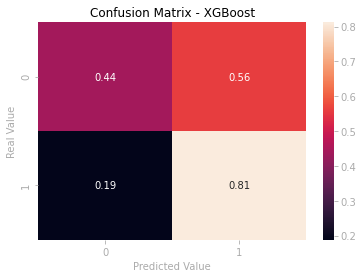

In [ ]:
# финальная модель XGBoost
xgb = XGBClassifier(max_depth=3, learning_rate=0.0001, n_estimators=50, gamma=1, min_child_weight=6)
xgb.fit(X_train_rus, y_train_rus)

# Прогноз модели (Prediction)
X_test_xgb = scaler.transform(X_test)
y_pred_xgb = xgb.predict(X_test_xgb)

# вывод на экран классификации
print(classification_report(y_test, y_pred_xgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_xgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - XGBoost')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

              precision    recall  f1-score   support

           0       0.91      0.62      0.74      8771
           1       0.25      0.68      0.37      1665

    accuracy                           0.63     10436
   macro avg       0.58      0.65      0.55     10436
weighted avg       0.81      0.63      0.68     10436



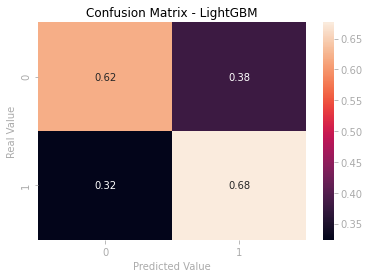

In [ ]:
# final LightGBM model
lgb = LGBMClassifier(num_leaves=70, max_depth=5, learning_rate=0.01, min_data_in_leaf=400)
lgb.fit(X_train_rus, y_train_rus)

# Прогноз модели (Prediction)
X_test_lgb = scaler.transform(X_test)
y_pred_lgb = lgb.predict(X_test_lgb)

# вывод на экран классификации
print(classification_report(y_test, y_pred_lgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_lgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - LightGBM')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

              precision    recall  f1-score   support

           0       0.91      0.67      0.77      8771
           1       0.27      0.64      0.38      1665

    accuracy                           0.66     10436
   macro avg       0.59      0.65      0.57     10436
weighted avg       0.81      0.66      0.71     10436



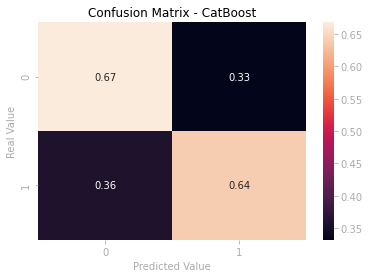

In [ ]:
# final CatBoost model
cb = CatBoostClassifier(learning_rate=0.03, depth=6, l2_leaf_reg=5, logging_level='Silent')
cb.fit(X_train_rus, y_train_rus)

# Прогноз модели (Prediction)
X_test_cb = scaler.transform(X_test)
y_pred_cb = cb.predict(X_test_cb)

# Сведения о классификации
print(classification_report(y_test, y_pred_cb))

# Матрица неточностей (англ. Confusion Matrix) — это таблица или диаграмма,
# показывающая точность прогнозирования классификатора в отношении двух и более классов.
# Прогнозы классификатора находятся на оси X, а результат (точность) — на оси Y.

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_cb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - CatBoost')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()